# Continuos Regression with *KQM*

### Concept

We will set `output_dim = 2` so that the model would predict a $2-\dim$ vector: $[cos^2\theta, sin^2\theta]$, and we will actually do the inference over $\theta$. Therefore, the range of the output variable must be within $[0, \pi/2]$.

### Import libraries

In [10]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn import metrics
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.layers import Input, Dense, Dropout, Activation
from keras.models import Model
from keras import optimizers
from keras import losses
import concurrent.futures
from itertools import product
from keras.layers import Input, Dense, Reshape
import kqm
import itertools
print("Tensorflow version:",tf.__version__)

Tensorflow version: 2.15.0


### Check GPU

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Sep 26 16:03:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A2000 8GB Lap...    Off | 00000000:01:00.0 Off |                  N/A |
| N/A   53C    P8               4W /  40W |      7MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Loading Dataset

## RE: Real Estate Valuation
https://archive.ics.uci.edu/dataset/477/real+estate+valuation+data+set

In [3]:
#!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo 

# fetch dataset 
real_estate_valuation = fetch_ucirepo(id=477) 
  
# data (as pandas dataframes) 
X = real_estate_valuation.data.features 
y = real_estate_valuation.data.targets 

## 70% - 30% Hold Out and MinMax Scaling for `y` 

In [4]:
from sklearn.model_selection import train_test_split

# Split data into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

X_train = np.asarray(X_train)
X_test = np.asarray(X_test)

scaler_x = StandardScaler()
scaler_x.fit(X_train)
X_train = scaler_x.transform(X_train)
X_test = scaler_x.transform(X_test)

scaler = MinMaxScaler(feature_range=(0.2, np.pi/2-0.2))
scaler.fit(y_train)
y_train = scaler.transform(y_train)
#y_test = scaler.transform(y_test))
y_train = np.asarray(y_train).reshape(-1)
y_test = np.asarray(y_test).reshape(-1)

print(f"Training features size: {X_train.shape}")
print(f"Training labels size: {y_train.shape}")

Training set size: (289, 6)
Test set size: (125, 6)
Training features size: (289, 6)
Training labels size: (289,)


## Defining KQM-Model

In [ ]:
n_comp=32

In [17]:
class KQMModel:
    def __init__(self,
                 encoding_dim,
                 kernel_function,
                 num_hidden_layerss,
                 input_shape=(6,),
                 output_dim=2,
                 n_comp=n_comp,
                 sigma=0.1,
                 use_dense_layers=True):
        self.encoding_dim = encoding_dim
        self.kernel_function = kernel_function
        self.num_hidden_layerss = num_hidden_layerss
        self.input_shape = input_shape
        self.output_dim = output_dim
        self.n_comp = n_comp
        self.sigma = sigma
        self.use_dense_layers = use_dense_layers  # New parameter tio turn off the dense layer model
        self.encoder = None
        self.encoder_aux = None
        self.kqm_class_encoded = None
        self.kqm_class_out = None
        self.kqm_unit_encoded = None
        self.kqm_unit_out = None
        self.kernel_encoded = None  # almacenamos la instancia de kernel
        self.kernel_out = None  # almacenamos la instancia de kernel
        self.build_model()

    def build_model(self):
        inputs = Input(shape=self.input_shape)
        
        if self.use_dense_layers:
            encoded = Dense(self.encoding_dim, activation='relu')(inputs)
            encoded = Dropout(0.1)(encoded)
            if self.num_hidden_layerss == 2:
                encoded = Dense(self.encoding_dim, activation='relu')(encoded)
                encoded = Dropout(0.1)(encoded)
            out = Dense(self.encoding_dim)(encoded)
            encoded = Activation('tanh')(out)
        else:
            # Skip dense layers, directly output the input
            encoded = inputs
            out = inputs
            #self.encoding_dim=1
        
        self.encoder = Model(inputs, encoded)
        self.encoder_aux = Model(inputs, out)

        self.kqm_class_encoded, self.kqm_unit_encoded, self.kernel_encoded = self.build_kqm_class(inputs, encoded)
        self.kqm_class_out, self.kqm_unit_out, self.kernel_out = self.build_kqm_class(inputs, out)

    def build_kqm_class(self, inputs, tensor):
        if self.kernel_function == 'rbf':
          kernel = kqm.RBFKernelLayer(sigma=self.sigma, dim=self.encoding_dim)
        else:
          kernel = kqm.CosineKernelLayer()
        kqm_unit = kqm.KQMUnit(kernel=kernel,
                               dim_x=self.encoding_dim,
                               dim_y=self.output_dim,
                               n_comp=self.n_comp)

        rho_x = kqm.pure2dm(tensor)
        rho_y = kqm_unit(rho_x)
        probs = kqm.dm2discrete(rho_y)
        probs_0_sqrt = tf.sqrt(probs[:, 0])  # Assuming probs is a 2D array, take the first column
        theta = tf.acos(probs_0_sqrt)
        return Model(inputs, theta), kqm_unit, kernel

    def summary(self):
        print("Encoder:")
        self.encoder.summary()
        print("Encoder Aux:")
        self.encoder_aux.summary()
        print("KQM Class Encoded:")
        self.kqm_class_encoded.summary()
        print("KQM Class Out:")
        self.kqm_class_out.summary()

## Training and Test

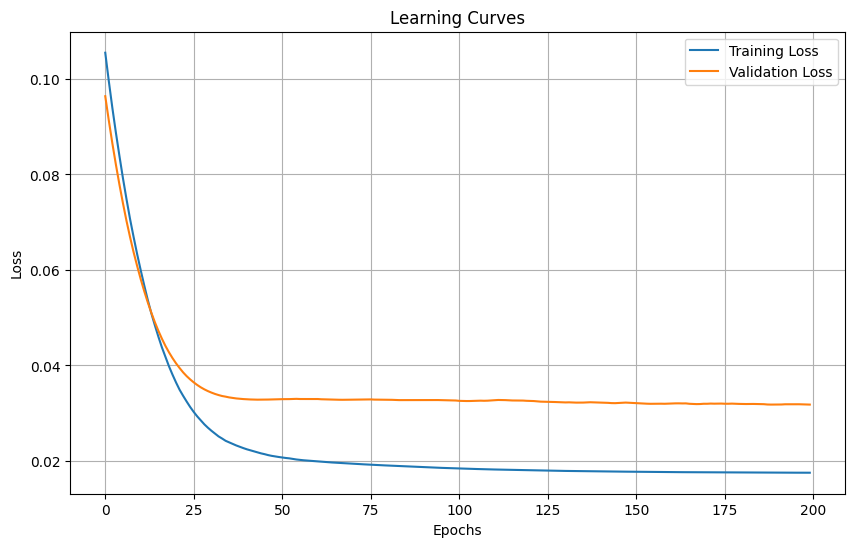

MAE = 10.63386221923828
MSE = 168.04896607990602
R^2 = -0.004926592002590047


In [12]:
stoppping_a = EarlyStopping(
                        monitor="val_loss",
                        min_delta=0,
                        patience=50,
                        verbose=0,
                        mode="min",
                        baseline=None,
                        restore_best_weights=True,
                        start_from_epoch=0,
                    )

kernel = 'rbf'
learning_rate = 0.001
encoding_dim = 6
num_hidden_layer = 1

kqm_model = KQMModel(encoding_dim = encoding_dim, kernel_function = kernel, num_hidden_layerss = num_hidden_layer, use_dense_layers=False)
kqm_model.encoder.trainable = True

kqm_model.kqm_class_encoded.compile(
          optimizer=optimizers.Adam(learning_rate=learning_rate),
          loss=losses.mse)

np.random.seed(42)
indices = np.random.choice(X_train.shape[0], size=n_comp, replace=False)
selected_samples = X_train[indices]
kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(selected_samples,verbose=0))
#kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(X,verbose=0))

history = kqm_model.kqm_class_encoded.fit(X_train, y_train,
          validation_split = 0.2,
          epochs=200,
          batch_size=32,
          verbose=0,
          callbacks=[stoppping_a])

# Plotting the learning curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

y_pred = scaler.inverse_transform(kqm_model.kqm_class_encoded.predict(X_test, verbose = 0).reshape(-1, 1)).reshape(-1)
print('MAE =',mean_absolute_error(y_test, y_pred))
print('MSE =',mean_squared_error(y_test, y_pred))
print('R^2 =',r2_score(y_test, y_pred))

# Initializing weights `c_y`

ok


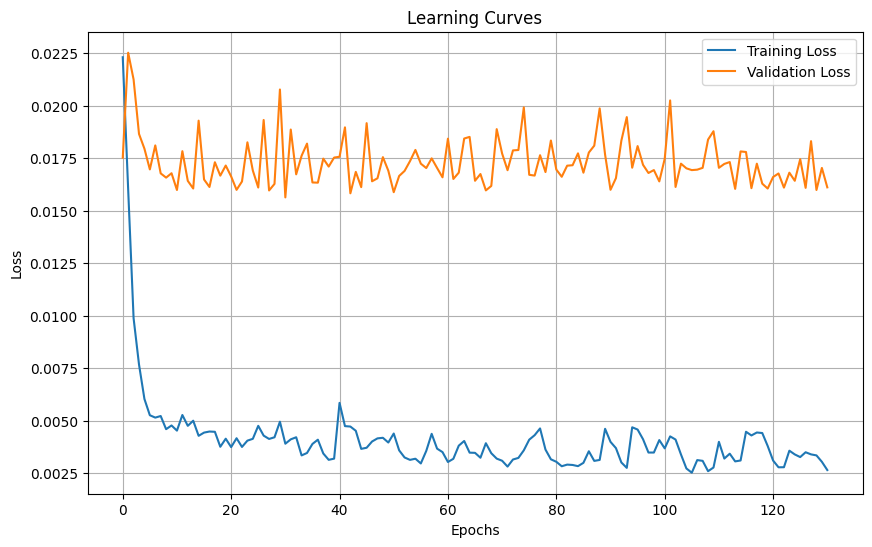

MAE = 5.434691899108887
MSE = 57.87488137960528
R^2 = 0.6539103532496223


In [13]:
stoppping_a = EarlyStopping(
                        monitor="val_loss",
                        min_delta=0,
                        patience=100,
                        verbose=0,
                        mode="min",
                        baseline=None,
                        restore_best_weights=True,
                        start_from_epoch=0,
                    )

kernel = 'rbf'
learning_rate = 0.1
encoding_dim = 6
num_hidden_layer = 1

kqm_model = KQMModel(encoding_dim = encoding_dim, kernel_function = kernel, num_hidden_layerss = num_hidden_layer, use_dense_layers=False)
kqm_model.encoder.trainable = True

kqm_model.kqm_class_encoded.compile(
          optimizer=optimizers.Adam(learning_rate=learning_rate),
          loss=losses.mse)

np.random.seed(42)
indices = np.random.choice(X_train.shape[0], size=n_comp, replace=False)
selected_samples = X_train[indices]
selected_labels = y_train[indices]
cos_values = np.cos(selected_labels)
sin_values = np.sin(selected_labels)
kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(selected_samples,verbose=0))
kqm_model.kqm_unit_encoded.c_y.assign(np.column_stack((cos_values, sin_values)))
print('ok')

history = kqm_model.kqm_class_encoded.fit(X_train, y_train,
          validation_split = 0.2,
          epochs=200,
          batch_size=32,
          verbose=0,
          callbacks=[stoppping_a])

# Plotting the learning curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

y_pred = scaler.inverse_transform(kqm_model.kqm_class_encoded.predict(X_test, verbose = 0).reshape(-1, 1)).reshape(-1)
print('MAE =',mean_absolute_error(y_test, y_pred))
print('MSE =',mean_squared_error(y_test, y_pred))
print('R^2 =',r2_score(y_test, y_pred))

It seem like initializing `c_y` worhts it.

# Hyper-parameter exploration

We are going to explore:
```
learning_rates = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 1e-1]
kernels = ['rbf', 'cos']
```

In [13]:
# Defining hyperparams to explore
learning_rates = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 1e-1]
kernels = ['rbf', 'cos']

# Some fixed hyper-params
encoding_dim = 6
num_hidden_layer = 1
n_comp=32

# For saving:
best_MSE = 0
best_model = None
best_hyperparameters = None

In [14]:
class KQMModel:
    def __init__(self,
                 encoding_dim,
                 kernel_function,
                 num_hidden_layerss,
                 input_shape=(6,),
                 output_dim=2,
                 n_comp=n_comp,
                 sigma=0.1,
                 use_dense_layers=True):
        self.encoding_dim = encoding_dim
        self.kernel_function = kernel_function
        self.num_hidden_layerss = num_hidden_layerss
        self.input_shape = input_shape
        self.output_dim = output_dim
        self.n_comp = n_comp
        self.sigma = sigma
        self.use_dense_layers = use_dense_layers  # New parameter tio turn off the dense layer model
        self.encoder = None
        self.encoder_aux = None
        self.kqm_class_encoded = None
        self.kqm_class_out = None
        self.kqm_unit_encoded = None
        self.kqm_unit_out = None
        self.kernel_encoded = None  # almacenamos la instancia de kernel
        self.kernel_out = None  # almacenamos la instancia de kernel
        self.build_model()

    def build_model(self):
        inputs = Input(shape=self.input_shape)
        
        if self.use_dense_layers:
            encoded = Dense(self.encoding_dim, activation='relu')(inputs)
            encoded = Dropout(0.1)(encoded)
            if self.num_hidden_layerss == 2:
                encoded = Dense(self.encoding_dim, activation='relu')(encoded)
                encoded = Dropout(0.1)(encoded)
            out = Dense(self.encoding_dim)(encoded)
            encoded = Activation('tanh')(out)
        else:
            # Skip dense layers, directly output the input
            encoded = inputs
            out = inputs
            #self.encoding_dim=1
        
        self.encoder = Model(inputs, encoded)
        self.encoder_aux = Model(inputs, out)

        self.kqm_class_encoded, self.kqm_unit_encoded, self.kernel_encoded = self.build_kqm_class(inputs, encoded)
        self.kqm_class_out, self.kqm_unit_out, self.kernel_out = self.build_kqm_class(inputs, out)

    def build_kqm_class(self, inputs, tensor):
        if self.kernel_function == 'rbf':
          kernel = kqm.RBFKernelLayer(sigma=self.sigma, dim=self.encoding_dim)
        else:
          kernel = kqm.CosineKernelLayer()
        kqm_unit = kqm.KQMUnit(kernel=kernel,
                               dim_x=self.encoding_dim,
                               dim_y=self.output_dim,
                               n_comp=self.n_comp)

        rho_x = kqm.pure2dm(tensor)
        rho_y = kqm_unit(rho_x)
        probs = kqm.dm2discrete(rho_y)
        probs_0_sqrt = tf.sqrt(probs[:, 0])  # Assuming probs is a 2D array, take the first column
        theta = tf.acos(probs_0_sqrt)
        return Model(inputs, theta), kqm_unit, kernel

    def summary(self):
        print("Encoder:")
        self.encoder.summary()
        print("Encoder Aux:")
        self.encoder_aux.summary()
        print("KQM Class Encoded:")
        self.kqm_class_encoded.summary()
        print("KQM Class Out:")
        self.kqm_class_out.summary()

In [16]:
best_MSE = 1000

for lr, kernel in itertools.product(learning_rates, kernels):
    print(f"Running experiment with learning_rate={lr} and kernel={kernel}")

    stoppping_a = EarlyStopping(
                            monitor="val_loss",
                            min_delta=0,
                            patience=50,
                            verbose=0,
                            mode="min",
                            baseline=None,
                            restore_best_weights=True,
                            start_from_epoch=0,
                        )
    
    kqm_model = KQMModel(encoding_dim = encoding_dim, kernel_function = kernel, num_hidden_layerss = num_hidden_layer, use_dense_layers=False)
    kqm_model.encoder.trainable = True
    
    kqm_model.kqm_class_encoded.compile(
              optimizer=optimizers.Adam(learning_rate=lr),
              loss=losses.mse)
    
    np.random.seed(42)
    indices = np.random.choice(X_train.shape[0], size=n_comp, replace=False)
    selected_samples = X_train[indices]
    kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(selected_samples,verbose=0))
    #kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(X,verbose=0))
    
    kqm_model.kqm_class_encoded.fit(X_train, y_train,
              validation_split = 0.2,
              epochs=200,
              batch_size=32,
              verbose=0,
              callbacks=[stoppping_a])
    
    y_pred = scaler.inverse_transform(kqm_model.kqm_class_encoded.predict(X_test, verbose = 0).reshape(-1, 1)).reshape(-1)
    print('MAE =',mean_absolute_error(y_test, y_pred))
    print('MSE =',mean_squared_error(y_test, y_pred))
    print('R^2 =',r2_score(y_test, y_pred))

    if mean_squared_error(y_test, y_pred) < best_MSE:
        best_MSE = mean_squared_error(y_test, y_pred)
        best_model = kqm_model
        best_hyperparameters = (lr, kernel)
        print("New best model")

print("Best hyper-parameters:", best_hyperparameters)

Running experiment with learning_rate=1e-05 and kernel=rbf
MAE = 25.957179260253906
MSE = 834.4867642605573
R^2 = -3.9901999378019584
New best model
Running experiment with learning_rate=1e-05 and kernel=cos
MAE = 25.65498681640625
MSE = 818.1336967543465
R^2 = -3.8924091998929216
New best model
Running experiment with learning_rate=5e-05 and kernel=rbf
MAE = 19.934997491455082
MSE = 537.5586401305363
R^2 = -2.2145807548203664
New best model
Running experiment with learning_rate=5e-05 and kernel=cos
MAE = 16.35012899169922
MSE = 379.3519393579169
R^2 = -1.2685105447614413
New best model
Running experiment with learning_rate=0.0001 and kernel=rbf
MAE = 14.986481170654299
MSE = 324.73124264326003
R^2 = -0.9418808017604192
New best model
Running experiment with learning_rate=0.0001 and kernel=cos
MAE = 11.362019146728517
MSE = 187.61871445018335
R^2 = -0.12195296232098807
New best model
Running experiment with learning_rate=0.0005 and kernel=rbf
MAE = 11.13396420288086
MSE = 180.185173647

```
Running experiment with learning_rate=0.1 and kernel=rbf
MAE = 5.2750650314331065
MSE = 51.4152715199899
R^2 = 0.6925385809222816
New best model
```

## Adding an Encoder

We are going to explore:
```
learning_rates = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 1e-1]
kernels = ['rbf', 'cos']
encoding_dim = [6, 8, 16]
num_hidden_layer = [1,2]
```

In [23]:
# Defining hyperparams to explore
learning_rates = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 1e-1]
kernels = ['rbf', 'cos']
encoding_dim = [6, 8, 16]
num_hidden_layers = [1,2]

# Some fixed hyper-params

n_comp=32

# For saving:
best_MSE = 0
best_model = None
best_hyperparameters = None

In [24]:
class KQMModel:
    def __init__(self,
                 encoding_dim,
                 kernel_function,
                 num_hidden_layerss,
                 input_shape=(6,),
                 output_dim=2,
                 n_comp=n_comp,
                 sigma=0.1,
                 use_dense_layers=True):
        self.encoding_dim = encoding_dim
        self.kernel_function = kernel_function
        self.num_hidden_layerss = num_hidden_layerss
        self.input_shape = input_shape
        self.output_dim = output_dim
        self.n_comp = n_comp
        self.sigma = sigma
        self.use_dense_layers = use_dense_layers  # New parameter tio turn off the dense layer model
        self.encoder = None
        self.encoder_aux = None
        self.kqm_class_encoded = None
        self.kqm_class_out = None
        self.kqm_unit_encoded = None
        self.kqm_unit_out = None
        self.kernel_encoded = None  # almacenamos la instancia de kernel
        self.kernel_out = None  # almacenamos la instancia de kernel
        self.build_model()

    def build_model(self):
        inputs = Input(shape=self.input_shape)
        
        if self.use_dense_layers:
            encoded = Dense(self.encoding_dim, activation='relu')(inputs)
            encoded = Dropout(0.1)(encoded)
            if self.num_hidden_layerss == 2:
                encoded = Dense(self.encoding_dim, activation='relu')(encoded)
                encoded = Dropout(0.1)(encoded)
            out = Dense(self.encoding_dim)(encoded)
            encoded = Activation('tanh')(out)
        else:
            # Skip dense layers, directly output the input
            encoded = inputs
            out = inputs
            #self.encoding_dim=1
        
        self.encoder = Model(inputs, encoded)
        self.encoder_aux = Model(inputs, out)

        self.kqm_class_encoded, self.kqm_unit_encoded, self.kernel_encoded = self.build_kqm_class(inputs, encoded)
        self.kqm_class_out, self.kqm_unit_out, self.kernel_out = self.build_kqm_class(inputs, out)

    def build_kqm_class(self, inputs, tensor):
        if self.kernel_function == 'rbf':
          kernel = kqm.RBFKernelLayer(sigma=self.sigma, dim=self.encoding_dim)
        else:
          kernel = kqm.CosineKernelLayer()
        kqm_unit = kqm.KQMUnit(kernel=kernel,
                               dim_x=self.encoding_dim,
                               dim_y=self.output_dim,
                               n_comp=self.n_comp)

        rho_x = kqm.pure2dm(tensor)
        rho_y = kqm_unit(rho_x)
        probs = kqm.dm2discrete(rho_y)
        probs_0_sqrt = tf.sqrt(probs[:, 0])  # Assuming probs is a 2D array, take the first column
        theta = tf.acos(probs_0_sqrt)
        return Model(inputs, theta), kqm_unit, kernel

    def summary(self):
        print("Encoder:")
        self.encoder.summary()
        print("Encoder Aux:")
        self.encoder_aux.summary()
        print("KQM Class Encoded:")
        self.kqm_class_encoded.summary()
        print("KQM Class Out:")
        self.kqm_class_out.summary()

In [25]:
best_MSE = 1000

for lr, kernel, encoding_dim, num_hidden_layer in itertools.product(learning_rates, kernels, encoding_dim, num_hidden_layers):
    print(f"Running experiment with learning_rate={lr}, kernel={kernel}, encoding_dim={encoding_dim} and num_h_l={num_hidden_layer}")

    stoppping_a = EarlyStopping(
                            monitor="val_loss",
                            min_delta=0,
                            patience=50,
                            verbose=0,
                            mode="min",
                            baseline=None,
                            restore_best_weights=True,
                            start_from_epoch=0,
                        )
    
    kqm_model = KQMModel(encoding_dim = encoding_dim, kernel_function = kernel, num_hidden_layerss = num_hidden_layer, use_dense_layers=True)
    kqm_model.encoder.trainable = True
    
    kqm_model.kqm_class_encoded.compile(
              optimizer=optimizers.Adam(learning_rate=lr),
              loss=losses.mse)
    
    np.random.seed(42)
    indices = np.random.choice(X_train.shape[0], size=n_comp, replace=False)
    selected_samples = X_train[indices]
    kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(selected_samples,verbose=0))
    #kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(X,verbose=0))
    
    kqm_model.kqm_class_encoded.fit(X_train, y_train,
              validation_split = 0.2,
              epochs=200,
              batch_size=32,
              verbose=0,
              callbacks=[stoppping_a])
    
    y_pred = scaler.inverse_transform(kqm_model.kqm_class_encoded.predict(X_test, verbose = 0).reshape(-1, 1)).reshape(-1)
    print('MAE =',mean_absolute_error(y_test, y_pred))
    print('MSE =',mean_squared_error(y_test, y_pred))
    print('R^2 =',r2_score(y_test, y_pred))

    if mean_squared_error(y_test, y_pred) < best_MSE:
        best_MSE = mean_squared_error(y_test, y_pred)
        best_model = kqm_model
        best_hyperparameters = (lr, kernel, encoding_dim, num_hidden_layer)
        print("New best model")

print("Best hyper-parameters:", best_hyperparameters)

Running experiment with learning_rate=1e-05, kernel=rbf, encoding_dim=6 and num_h_l=1
MAE = 26.23075244140625
MSE = 850.4416800740371
R^2 = -4.085609743337475
New best model
Running experiment with learning_rate=1e-05, kernel=rbf, encoding_dim=6 and num_h_l=2
MAE = 26.180637231445314
MSE = 845.9412185450427
R^2 = -4.058697150107829
New best model
Running experiment with learning_rate=1e-05, kernel=rbf, encoding_dim=8 and num_h_l=1
MAE = 26.155189904785157
MSE = 845.5611559123647
R^2 = -4.0564243896433405
New best model
Running experiment with learning_rate=1e-05, kernel=rbf, encoding_dim=8 and num_h_l=2
MAE = 26.16921810913086
MSE = 847.4097826397764
R^2 = -4.0674791089932905
Running experiment with learning_rate=1e-05, kernel=rbf, encoding_dim=16 and num_h_l=1
MAE = 25.960909118652342
MSE = 834.9713607828886
R^2 = -3.9930978070542524
New best model
Running experiment with learning_rate=1e-05, kernel=rbf, encoding_dim=16 and num_h_l=2
MAE = 25.976074951171874
MSE = 835.884134488899
R^2

```
Running experiment with learning_rate=0.005, kernel=cos, encoding_dim=6 and num_h_l=1
MAE = 5.158172692871094
MSE = 50.5153498060457
R^2 = 0.6979200794352391
New best model
```

So, an encoder doesn't improves the performance in this case.

In [31]:
y_test.max(), y_test.mean(), y_test.min()

(70.1, 36.91280000000001, 7.6)